In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import librosa
import librosa.display

from kymatio import Scattering1D
import torch
from tqdm import tqdm_notebook

In [2]:
from SimpleSpeechCommands import get_word_dict, read_list, load_data
from SimpleSpeechCommands import append_examples,partition_directory

In [3]:
word_to_label,label_to_word = get_word_dict()
path_dataset = '/home/edoardobucheli/TFSpeechCommands/train/audio'
#path_dataset = '/Users/edoardobucheli/Documents/MCC/Tesis/Kaggle_SpeechCommands/train/audio'
sr = 16000
file_length = 16384

In [4]:
training_files = read_list(path_dataset,'training_files.txt')
validation_files = read_list(path_dataset,'validation_files.txt')
testing_files = read_list(path_dataset,'testing_files.txt')

In [5]:
x_train,y_train = load_data(training_files,sr,file_length,path_dataset,word_to_label)
x_val,y_val = load_data(validation_files,sr,file_length,path_dataset,word_to_label)
x_test,y_test = load_data(testing_files,sr,file_length,path_dataset,word_to_label)

In [6]:
#backgrounds = partition_directory(path_dataset,'_background_noise_',sr,file_length)

In [7]:
#x_train,y_train = append_examples(x_train,y_train,backgrounds[:300],11)
#x_val,y_val = append_examples(x_val,y_val,backgrounds[300:320],11)
#x_test,y_test = append_examples(x_test,y_test,backgrounds[320:],11)

In [8]:
N_train,_ =  x_train.shape
N_val,_ = x_val.shape
N_test = x_test.shape

In [164]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(25112, 16384)
(25112,)
(3424, 16384)
(3424,)
(3430, 16384)
(3430,)


### Preprocess Data

In [10]:
T = 2**14 # Signal Length
J = 9     # Maximum Scale 2**J of the transform (about 30 milliseconds)
Q = 8    # Number of Wavelets per octave
log_eps = 1e-6

### Log-scattering transform

In [90]:
scattering = Scattering1D(J,T,Q)

In [155]:
x_train_2 = torch.from_numpy(x_train)
x_train_2 = x_train_2.type(torch.float32)

x_val_2 = torch.from_numpy(x_val)
x_val_2 = x_val_2.type(torch.float32)

In [196]:
scat_batch = 1000
steps = N_train // scat_batch + 1
val_steps = N_val // scat_batch + 1

In [165]:
Sx_all = torch.zeros(N_train,300, 32,dtype = torch.float32)
Sx_val_all = torch.zeros(N_val,300, 32,dtype = torch.float32)

In [166]:
meta = Scattering1D.compute_meta_scattering(J, Q)
order0 = (meta['order'] == 0)
order1 = (meta['order'] == 1)
order2 = (meta['order'] == 2)

In [198]:
for i in tqdm_notebook(range(steps)):
    start = i*scat_batch
    end = start + scat_batch
    
    if end >= N_train:
        end = N_train-1
    
    Sx_all[start:end] = scattering.forward(x_train_2[start:end])

In [199]:
for i in tqdm_notebook(range(val_steps)):
    start = i*scat_batch
    end = start + scat_batch
    
    if end >= N_val:
        end = N_val-1
    
    Sx_val_all[start:end] = scattering.forward(x_val_2[start:end])

In [200]:
Sx_all = torch.log(torch.abs(Sx_all) + log_eps)
Sx_val_all = torch.log(torch.abs(Sx_val_all) + log_eps)

In [201]:
Sx_order0 = Sx_all[:,order0,:]
Sx_order1 = Sx_all[:,order1,:]
Sx_order2 = Sx_all[:,order2,:]

Sx_val_order0 = Sx_val_all[:,order0,:]
Sx_val_order1 = Sx_val_all[:,order1,:]
Sx_val_order2 = Sx_val_all[:,order2,:]

In [202]:
x_order0 = Sx_order0.numpy()
x_order1 = Sx_order1.numpy()
x_order2 = Sx_order2.numpy()

x_val_order0 = Sx_val_order0.numpy()
x_val_order1 = Sx_val_order1.numpy()
x_val_order2 = Sx_val_order2.numpy()

In [203]:
print(x_order0.shape)
print(x_order1.shape)
print(x_order2.shape)

print(x_val_order0.shape)
print(x_val_order1.shape)
print(x_val_order2.shape)

(25112, 1, 32)
(25112, 62, 32)
(25112, 237, 32)
(3424, 1, 32)
(3424, 62, 32)
(3424, 237, 32)


In [204]:
from ProcessAudio import normalize_2D

In [205]:
x_order1_norm = normalize_2D(x_order1)
x_order2_norm = normalize_2D(x_order2)

x_val_order1_norm = normalize_2D(x_val_order1)
x_val_order2_norm = normalize_2D(x_val_order2)

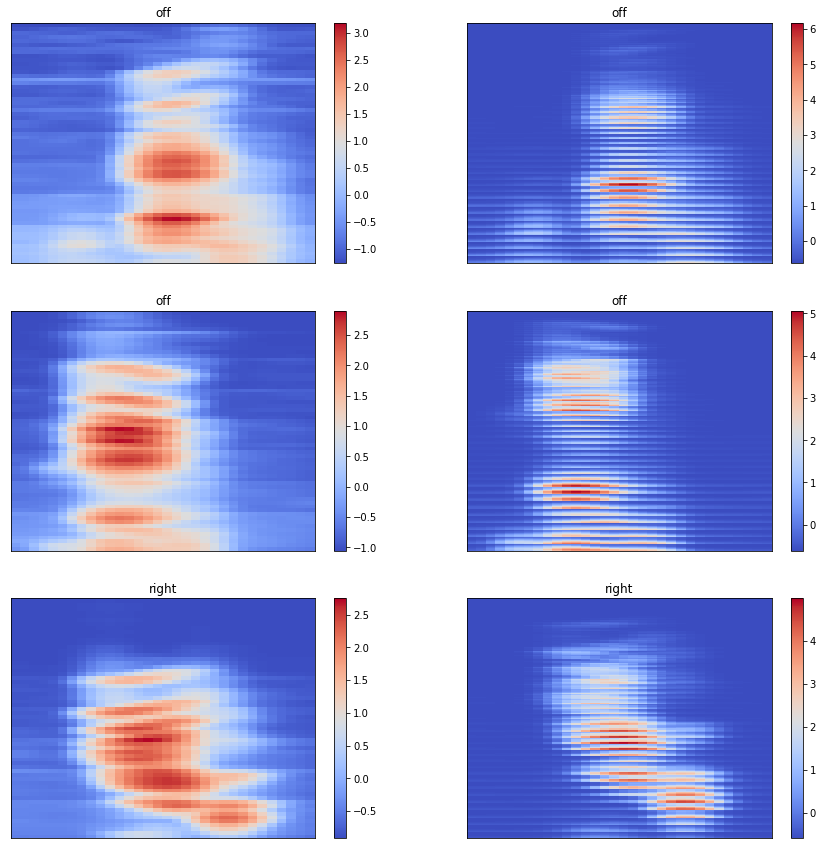

In [206]:
plt.figure(figsize=(15,15))

for i in range(3):
    ind = np.random.randint(25112)
    plt.subplot(3,2,i*2+1)
    librosa.display.specshow(x_order1_norm[ind])
    plt.colorbar()
    plt.title(label_to_word[y_train[ind]])
    plt.subplot(3,2,i*2+2)
    librosa.display.specshow(x_order2_norm[ind])
    plt.title(label_to_word[y_train[ind]])
    plt.colorbar()

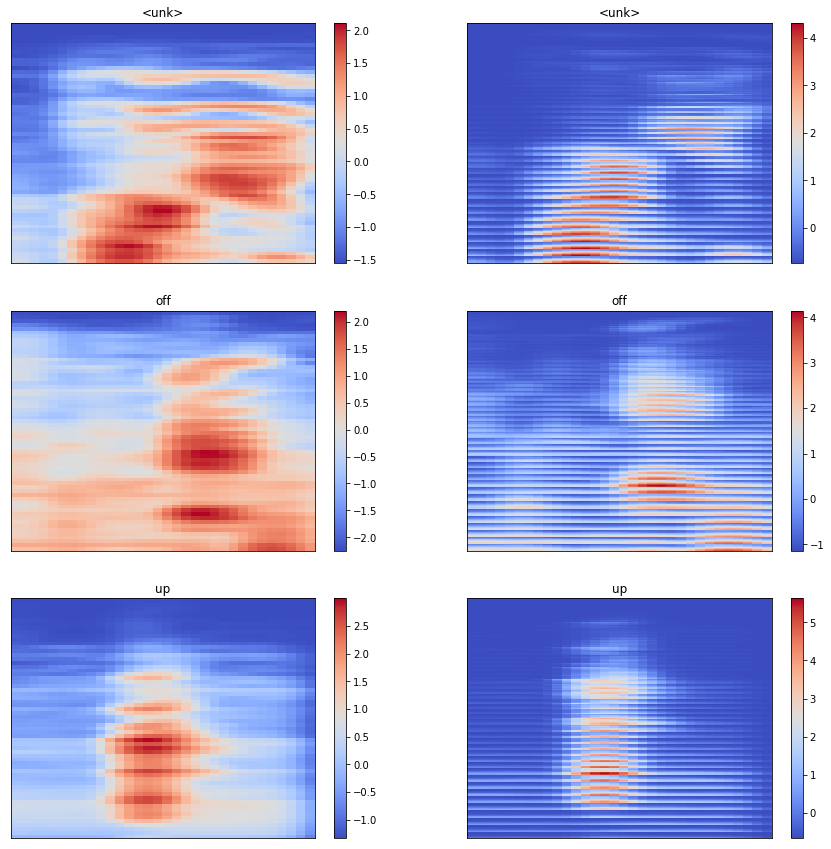

In [207]:
plt.figure(figsize=(15,15))

for i in range(3):
    ind = np.random.randint(N_val)
    plt.subplot(3,2,i*2+1)
    librosa.display.specshow(x_val_order1_norm[ind])
    plt.colorbar()
    plt.title(label_to_word[y_val[ind]])
    plt.subplot(3,2,i*2+2)
    librosa.display.specshow(x_val_order2_norm[ind])
    plt.title(label_to_word[y_val[ind]])
    plt.colorbar()

## Other Processing

In [208]:
from Utilities import make_oh

In [212]:
N_train, _,_ = x_order1_norm.shape
N_val, _ ,_= x_val_order1_norm.shape
#N_test, _ = x_test_2.shape

n_classes = len(np.unique(y_train))

In [214]:
y_train_oh = make_oh(y_train)
y_val_oh = make_oh(y_val)
#y_test_oh = make_oh(y_test)

In [216]:
print(x_order1_norm.shape)
print(y_train_oh.shape)
print(x_val_order1_norm.shape)
print(y_val_oh.shape)
#print(x_test.shape)
#print(y_test_oh.shape)

(25112, 62, 32)
(25112, 11)
(3424, 62, 32)
(3424, 11)


## CRNN1

In [217]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Activation, CuDNNGRU
from tensorflow.keras.layers import GRU, LSTM, TimeDistributed, Lambda, Dot, Softmax
from tensorflow.keras.layers import Conv2D, Conv1D, Reshape, Permute, GRUCell, LSTMCell
from tensorflow.keras.layers import Bidirectional, CuDNNLSTM, BatchNormalization, MaxPool1D
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Model
from tensorflow.keras.backend import squeeze,stack, expand_dims
from tensorflow.keras.optimizers import Adam

In [218]:
def CRNN_v1(input_shape, n_classes):
    
    X_input = Input(input_shape)
    
    X = Lambda(lambda q: expand_dims(q, -1), name='expand_dims') (X_input)
    
    X = Conv2D(32, kernel_size = [5,5], strides = [2,2],
               activation = relu, name = 'conv_1')(X)
    
    X = Conv2D(1,kernel_size=[1,1], strides = [1,1],
               activation = relu, name = 'conv_1x1')(X)
        
    X = Lambda(lambda q: squeeze(q, -1), name='squeeze_last_dim') (X)
        
    X = Permute((2,1)) (X)   
        
    X = CuDNNGRU(32, return_sequences = True)(X)
    
    X = CuDNNGRU(32, return_sequences = True)(X)
    
    X = Flatten()(X)
    
    X = Dense(64)(X)
    X = Dropout(0.5)(X)
    X = Activation(relu)(X)
    
    X = Dense(n_classes, activation = softmax)(X)
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [219]:
N_train, freq, time = x_order1_norm.shape

In [220]:
input_shape = (freq,time)
n_classes = 11

In [221]:
model = CRNN_v1(input_shape,n_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 62, 32)            0         
_________________________________________________________________
expand_dims (Lambda)         (None, 62, 32, 1)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 29, 14, 32)        832       
_________________________________________________________________
conv_1x1 (Conv2D)            (None, 29, 14, 1)         33        
_________________________________________________________________
squeeze_last_dim (Lambda)    (None, 29, 14)            0         
_________________________________________________________________
permute_8 (Permute)          (None, 14, 29)            0         
_________________________________________________________________
cu_dnngru_16 (CuDNNGRU)      (None, 14, 32)            6048      
__________

In [222]:
model.compile(optimizer=Adam(0.001),loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [234]:
model.fit(x_order1_norm,y_train_oh,batch_size=32,epochs = 10,validation_data=[x_val_order1_norm,y_val_oh])

Train on 25112 samples, validate on 3424 samples
Epoch 1/10
25112/25112 [==============================] - 5s 186us/step - loss: 0.2055 - acc: 0.9307 - val_loss: 0.4244 - val_acc: 0.8864
Epoch 2/10
25112/25112 [==============================] - 5s 186us/step - loss: 0.2045 - acc: 0.9323 - val_loss: 0.3866 - val_acc: 0.8969
Epoch 3/10
25112/25112 [==============================] - 4s 158us/step - loss: 0.1973 - acc: 0.9323 - val_loss: 0.3960 - val_acc: 0.8905
Epoch 4/10
25112/25112 [==============================] - 4s 158us/step - loss: 0.1918 - acc: 0.9344 - val_loss: 0.3891 - val_acc: 0.8949
Epoch 5/10
25112/25112 [==============================] - 4s 157us/step - loss: 0.1927 - acc: 0.9352 - val_loss: 0.3928 - val_acc: 0.8998
Epoch 6/10
25112/25112 [==============================] - 4s 158us/step - loss: 0.1796 - acc: 0.9378 - val_loss: 0.4251 - val_acc: 0.8838
Epoch 7/10
25112/25112 [==============================] - 4s 157us/step - loss: 0.1863 - acc: 0.9365 - val_loss: 0.4071 - v

In [228]:
N_train, freq_2, time_2 = x_order2_norm.shape

In [229]:
input_shape_2 = (freq_2,time_2)
n_classes = 11

In [230]:
model2 = CRNN_v1(input_shape_2,n_classes)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 237, 32)           0         
_________________________________________________________________
expand_dims (Lambda)         (None, 237, 32, 1)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 117, 14, 32)       832       
_________________________________________________________________
conv_1x1 (Conv2D)            (None, 117, 14, 1)        33        
_________________________________________________________________
squeeze_last_dim (Lambda)    (None, 117, 14)           0         
_________________________________________________________________
permute_10 (Permute)         (None, 14, 117)           0         
_________________________________________________________________
cu_dnngru_20 (CuDNNGRU)      (None, 14, 32)            14496     
__________

In [231]:
model2.compile(optimizer=Adam(0.001),loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [233]:
model2.fit(x_order2_norm,y_train_oh,batch_size=32,epochs = 10,validation_data=[x_val_order2_norm,y_val_oh])

Train on 25112 samples, validate on 3424 samples
Epoch 1/10
25112/25112 [==============================] - 5s 188us/step - loss: 0.7645 - acc: 0.7444 - val_loss: 0.5462 - val_acc: 0.8148
Epoch 2/10
25112/25112 [==============================] - 5s 180us/step - loss: 0.6104 - acc: 0.8034 - val_loss: 0.4962 - val_acc: 0.8309
Epoch 3/10
25112/25112 [==============================] - 5s 180us/step - loss: 0.5219 - acc: 0.8326 - val_loss: 0.4828 - val_acc: 0.8388
Epoch 4/10
25112/25112 [==============================] - 5s 184us/step - loss: 0.4668 - acc: 0.8501 - val_loss: 0.4337 - val_acc: 0.8572
Epoch 5/10
25112/25112 [==============================] - 5s 186us/step - loss: 0.4217 - acc: 0.8627 - val_loss: 0.4053 - val_acc: 0.8697
Epoch 6/10
25112/25112 [==============================] - 5s 183us/step - loss: 0.3900 - acc: 0.8747 - val_loss: 0.3844 - val_acc: 0.8776
Epoch 7/10
25112/25112 [==============================] - 5s 185us/step - loss: 0.3495 - acc: 0.8894 - val_loss: 0.4143 - v